In [1]:
#mount google drive to access files
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
path_to_folder="ENPM673/project2"
#the following paths allows access to video and images used for image stitching
my_video=f"/content/drive/MyDrive/{path_to_folder}/project2_video.mp4"
my_images=f"/content/drive/MyDrive/{path_to_folder}/images"
%cd /content/drive/MyDrive/$path_to_folder

Mounted at /content/drive/
/content/drive/MyDrive/ENPM673/project2


In [2]:
#import all the necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


To open the video file and get properties:
cv2.VideoCapture(my_video) → Opens the video file.
cap.isOpened() → Checks if the file is successfully opened.
cv2.CAP_PROP_FPS, cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT → Extract FPS, width, and height.

In [3]:
# to Open the video file
cap = cv2.VideoCapture(my_video)

# Check if the video is accessible and successfully opened
if not cap.isOpened():
    print("Error: Video file not found or cannot be opened. Check the file path.")
else:
    print("Video file loaded successfully!")

# Retrieve the video's frame rate (FPS) and resolution (width & height).
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Display video properties to confirm successful loading.
print(f"Resolution: {frame_width}x{frame_height}, FPS: {fps}")
cap.release()


Video file loaded successfully!
Resolution: 1280x720, FPS: 29


The following block is used to detect blurry frames , cv2.laplacian is used to compute edge sharpness.

In [4]:
# Function to check if a frame is blurry using Variance of Laplacian method
def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

# Open video file using openCV
cap = cv2.VideoCapture(my_video)

# Get video properties frames per second,width and height
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

#initialize counters for processes frames and blurry frames
frame_count = 0
blurry_frames = 0
filtered_frames = []

#Read and process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    frame_count += 1

    # Check if frame is blurry using ths is_blurry function
    if is_blurry(frame):
        blurry_frames += 1
        continue  # Skip blurry frames

    filtered_frames.append(frame) #store non-blurry frames in the list

cap.release()

# print stats on processes and blurry frames
print(f"Total frames processed: {frame_count}")
print(f"Blurry frames removed: {blurry_frames}")


Total frames processed: 269
Blurry frames removed: 0


Convert to Grayscale & Detect Edges

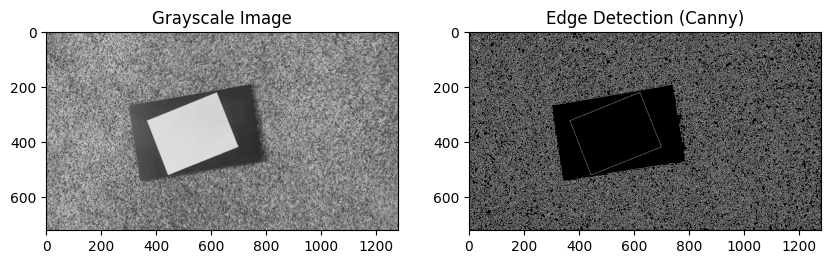

In [5]:
# Use the first non-blurry frame for testing
test_frame = filtered_frames[0]

# Convert to grayscale
gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, 50, 150)

# Display result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection (Canny)')

plt.show()


**Using Hough Transform to Find Paper Edges**

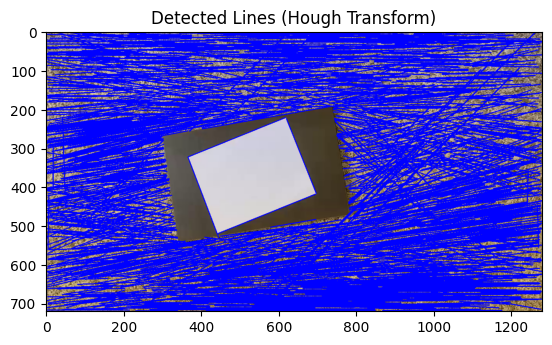

In [6]:
# Apply Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw lines on the original image
line_image = test_frame.copy()

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw blue lines

# Display result
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines (Hough Transform)')
plt.show()


**Detect Corners Using Harris Corner**



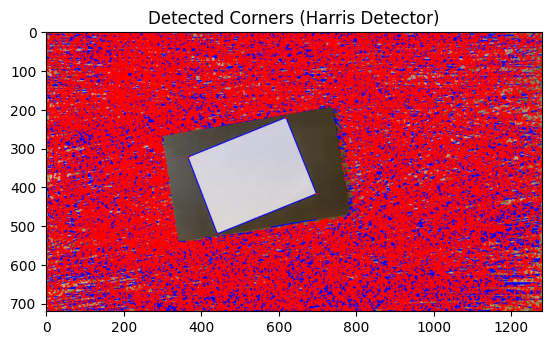

In [7]:
# Harris Corner Detection
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)  # Dilate for better visibility

# Mark detected corners in red
corner_image = line_image.copy()
corner_image[dst > 0.01 * dst.max()] = [0, 0, 255]  # Highlight corners

# Display result
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Corners (Harris Detector)')
plt.show()


**Filter & Highlight the Four Corners**

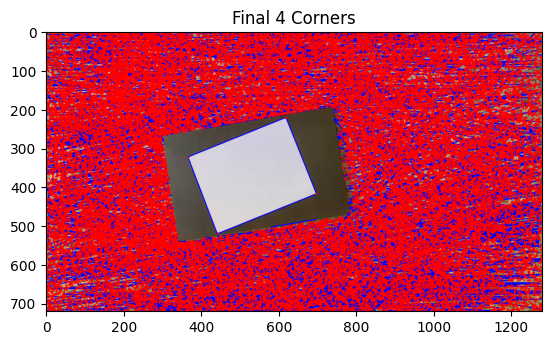

In [8]:
# Extract the strongest 4 corners
corners = np.argwhere(dst > 0.01 * dst.max())  # Get corner coordinates
corners = sorted(corners, key=lambda x: (x[0], x[1]))[:4]  # Keep top 4 corners

# Draw the four detected corners
for corner in corners:
    x, y = corner[1], corner[0]
    cv2.circle(corner_image, (x, y), 5, (0, 255, 0), -1)  # Green circles for final corners

# Display result
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
plt.title('Final 4 Corners')
plt.show()


**Overlay Results & Save Processed video**

In [9]:
# Reopen video to process frame-by-frame
cap = cv2.VideoCapture(my_video)
output_video_path = f"/content/drive/MyDrive/{path_to_folder}/output_video.mp4"

# Define the codec and create video writer object to save the o/p video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0

#loop through the video frames until the end
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1 #increment the frame counter

    # Skip processing for blurry frames
    if is_blurry(frame):
        continue

 # Convert the frame to grayscale for edge detection and corner detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect edges in the grayscale image using Canny Edge Detection
    edges = cv2.Canny(gray, 50, 150)

    # Detect lines in the edge-detected image using the Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # If lines are detected, draw them on the original frame
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0] #extract line end points
            cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw the line in blue (BGR: (255,0,0)) with a thickness of 2px

    # Detect corners using the Harris Corner Detection algorithm
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    frame[dst > 0.01 * dst.max()] = [0, 0, 255]

    # Write to output video
    out.write(frame)

cap.release() #close the video file
out.release() # Finish writing and close the output video file

# Print a message indicating that the processing is complete
print(f"Processing complete! Output video saved at: {output_video_path}")


Processing complete! Output video saved at: /content/drive/MyDrive/ENPM673/project2/output_video.mp4


## Problem 2: Image Stitching for a Panoramic View

 1. we will use SIFT to extract featured
 2. Using FLANN to match features
 3. Compute homographies (RANSAC)
 4. Warp and stitch images into a panorama







**Load and Display Images**

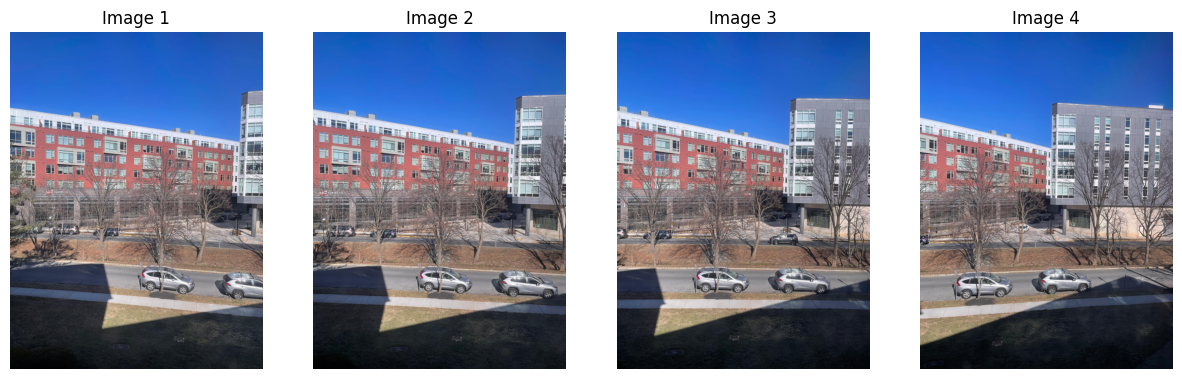

In [3]:
# Load images dynamically from the specified folder
images_folder = my_images

# List all images in the folder that match valid image formats
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.lower().endswith(valid_extensions)])

# Load images from the folder
images = [cv2.imread(img) for img in image_files]

# Convert images from BGR (OpenCV format) to RGB for correct display in Matplotlib
images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

# Create a figure to display all images in a single row
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

# Iterate through images and display them
for i, img in enumerate(images_rgb):
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis("off")

# Display all images in the output window
plt.show()


# **Feature Detection (Using SIFT)**

In [4]:
# Convert images to grayscale for feature extraction
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Initialize SIFT detector for feature extraction
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for each grayscale image
keypoints_descriptors = [sift.detectAndCompute(img, None) for img in gray_images]

# Extract keypoints and descriptors separately
keypoints_list, descriptors_list = zip(*keypoints_descriptors)

# Print confirmation message with the total number of processed images
print(f"Feature detection complete! Processed {len(keypoints_list)} images.")


Feature detection complete! Processed 4 images.


# **Feature Matching Between Consecutive Images**



In [5]:
# Initialize FLANN (Fast Library for Approximate Nearest Neighbors) Matcher
FLANN_INDEX_KDTREE = 1 # Specifies the KD-Tree algorithm for FLANN
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)  # Use 5 KD-Trees for searching
search_params = dict(checks=50)# Perform 50 checks to find the best match

# Create a FLANN-based matcher with the specified parameters
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Initialize an empty list to store matches between consecutive images
matches = []

# Iterate through consecutive image pairs to find feature matches
for i in range(len(images) - 1):
    match = flann.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)

    # Apply Lowe’s ratio test to filter strong matches
    good_matches = [m for m, n in match if m.distance < 0.5 * n.distance]
    matches.append(good_matches)

# Print confirmation message after feature matching is complete
print("Feature matching complete!")


Feature matching complete!


# **Computing Homographies Using RANSAC**

In [6]:
# Function to compute homography using RANSAC
def get_homography(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) #Extract matching points from image 1
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) #Extract matching points from image 2

    # Compute the homography matrix using RANSAC to filter out incorrect matches
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # RANSAC threshold of 5.0 to remove outliers
    return H, mask

# Compute homographies for consecutive image pairs
homographies = []
#loop through each pair of matched images and extract keypoints from the images
for i in range(len(matches)):
    kp1, _ = keypoints_descriptors[i]
    kp2, _ = keypoints_descriptors[i + 1]
    H, mask = get_homography(kp1, kp2, matches[i]) # Compute homography between the two images
    homographies.append(H)

print("Homographies computed successfully!")



Homographies computed successfully!


# **Warp & Stitch Images**

In [9]:
#Blends two images smoothly using a feathered mask to reduce visible seams.
def feather_blend(img1, img2, mask, feather_amount=50):
    mask = mask.astype(np.float32) / 255  # Normalize mask to [0,1]

    # Ensure feathering amount is a positive odd number and does not exceed mask size
    feather_amount = max(3, feather_amount | 1)
    feather_amount = min(feather_amount, min(mask.shape[:2]) - 1)
    if feather_amount % 2 == 0:  # Ensure it's an odd number
        feather_amount += 1

    # Apply Gaussian blur to feather the mask for smoother blending
    mask = cv2.GaussianBlur(mask, (feather_amount, feather_amount), 0)

    # Convert the mask to a 3-channel format and blend the images
    mask = cv2.merge([mask]*3)
    blended = img1 * (1 - mask) + img2 * mask
    return blended.astype(np.uint8)

#Warps image2 to align with image1 using homography H and applies feather blending.
def warp_images(image1, image2, H):
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]

    # Warp image2 to the coordinate space of image1 and create a blank canvas for stitching
    output_size = (width1 + width2, max(height1, height2))
    warped_image2 = cv2.warpPerspective(image2, H, output_size)

    # Place image1 on the blank canvas and generate a binary mask for blending
    panorama = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)
    panorama[:height1, :width1] = image1
    mask = cv2.cvtColor(warped_image2, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]

    # Blend the images smoothly using feather blending
    panorama = feather_blend(panorama, warped_image2, mask, feather_amount=80)
    return panorama

# Initialize the panorama with the first image and stitch all images together
panorama = images[0]
for i in range(1, len(images)):
    H = homographies[i - 1]
    panorama = warp_images(panorama, images[i], H)  # Warp and blend the images


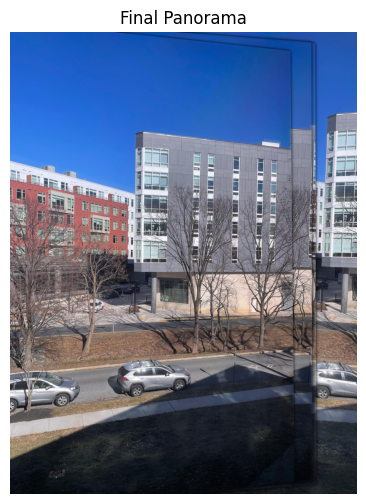

In [11]:
# Convert the stitched image to grayscale
gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)

# Threshold to find non-black regions
_, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)

# Find contours of the non-black areas
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the bounding box of the largest contour
if len(contours) > 0:
    x, y, w, h = cv2.boundingRect(contours[0])
    panorama = panorama[y:y+h, x:x+w]

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama")
plt.axis("off")
plt.show()


B)  **In general, why does panoramic mosaicing work better when the camera is only allowed to rotate at its camera
center?**

Ans:Panoramic mosaicing works best when the camera only rotates around its center because all images share the same perspective. This allows the transformation between images to be described by a single homography matrix, making alignment and stitching much easier. When the camera rotates in place, the relative positions of objects in the scene remain consistent, avoiding perspective distortion and parallax effects (where objects at different depths shift differently). As a result, feature matching (using SIFT or ORB) is more reliable, and the images blend seamlessly.

If the camera moves (translates) instead of rotating, objects in the scene appear to shift at different rates depending on their distance from the camera. This parallax effect makes feature matching more challenging and requires complex 3D transformations to correct for depth differences. Additionally, the stitching process struggles to align overlapping regions properly, leading to visible seams or distortions. By keeping the camera fixed at a single point and only rotating, panoramic stitching remains accurate, efficient, and visually smooth.
